##### import libs

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from copy import deepcopy
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

from utils import load_data, evaluate, plot_feature_importances

##### load data

In [2]:
user_item_data, user_meta_data, item_meta_data, test_pairs_data = load_data()

In [3]:
user_item_data_w_group_features = pd.read_parquet("data/user_item_data_w_group_features.parquet")
test_pairs_data_w_group_features = pd.read_parquet("data/test_pairs_data_w_group_features.parquet")

In [4]:
user_embeddings = np.load("dumps/user_embeddings.npy")
item_embeddings = np.load("dumps/item_embeddings.npy")
user_biases = np.load("dumps/user_biases.npy")
item_biases = np.load("dumps/item_biases.npy")
lightfm_scores = np.load("dumps/lightfm_scores.npy")
test_lightfm_scores = np.load("dumps/test_lightfm_scores.npy")

In [5]:
user_item_data_w_group_features["lightfm_scores"] = lightfm_scores.tolist()

In [6]:
test_pairs_data_w_group_features["lightfm_scores"] = test_lightfm_scores.tolist()

In [7]:
user_item_data_w_group_features.lightfm_scores = user_item_data_w_group_features.lightfm_scores.astype(np.float16)
test_pairs_data_w_group_features.lightfm_scores = test_pairs_data_w_group_features.lightfm_scores.astype(np.float16)

In [8]:
columns = list(set(user_item_data_w_group_features.columns.to_list()) - set([
    'bookmarks',
    'dislike',
    'explicit',
    'like',
    'share',
    'timespent',
]))

In [9]:
set(test_pairs_data_w_group_features.columns) == set(columns)

True

In [10]:
target = "like"

In [11]:
train_df, val_df = train_test_split(
    user_item_data_w_group_features[columns+[target]],
    test_size=0.15,
    random_state=42,
    shuffle=False,
)

In [13]:
def compute_lag(
        train_df,
        val_df,
        group_col,
        target_col,
        lag,
        ):
    train_df = train_df.copy()
    val_df = val_df.copy()
    grouped = train_df.groupby(group_col, as_index=False)
    lag_col_name = f"{target_col}_lag_{lag}"
    train_df[lag_col_name] = grouped[target_col].shift(lag).fillna(0).astype(np.int16)
    grouped = train_df.groupby(group_col, as_index=False)
    last_lag_by_user_id = grouped[lag_col_name].agg("last")
    val_df = val_df.merge(
        right=last_lag_by_user_id,
        on=group_col,
        how="left"
    )
    return train_df, val_df

In [14]:
train_df, val_df = compute_lag(
    train_df=train_df,
    val_df=val_df,
    group_col="user_id",
    target_col="like",
    lag=1
)

##### catboost

In [24]:
model = CatBoostClassifier(
    verbose=True,
    iterations=100,
    auto_class_weights="SqrtBalanced",
    # cat_features=["user_id", "source_id", "item_id"]
)

In [25]:
model.fit(train_df[-int(10e6):][columns+["like_lag_1"]],
          train_df[-int(10e6):][target])

Learning rate set to 0.5
0:	learn: 0.3068658	total: 660ms	remaining: 1m 5s
1:	learn: 0.2600158	total: 1.32s	remaining: 1m 4s
2:	learn: 0.2529469	total: 1.92s	remaining: 1m 2s
3:	learn: 0.2502112	total: 2.56s	remaining: 1m 1s
4:	learn: 0.2482747	total: 3.19s	remaining: 1m
5:	learn: 0.2469901	total: 3.81s	remaining: 59.7s
6:	learn: 0.2465285	total: 4.43s	remaining: 58.9s
7:	learn: 0.2456583	total: 5.02s	remaining: 57.8s
8:	learn: 0.2453069	total: 5.63s	remaining: 56.9s
9:	learn: 0.2448928	total: 6.23s	remaining: 56.1s
10:	learn: 0.2445718	total: 6.92s	remaining: 56s
11:	learn: 0.2443530	total: 7.45s	remaining: 54.7s
12:	learn: 0.2442059	total: 7.91s	remaining: 53s
13:	learn: 0.2440715	total: 8.46s	remaining: 52s
14:	learn: 0.2439361	total: 9.09s	remaining: 51.5s
15:	learn: 0.2438062	total: 9.67s	remaining: 50.8s
16:	learn: 0.2436771	total: 10.3s	remaining: 50.2s
17:	learn: 0.2433814	total: 10.9s	remaining: 49.6s
18:	learn: 0.2432605	total: 11.5s	remaining: 49s
19:	learn: 0.2431507	total:

In [28]:
catboost_proba = model.predict_proba(val_df[columns+["like_lag_1"]])

In [30]:
model.classes_

array([0, 1])

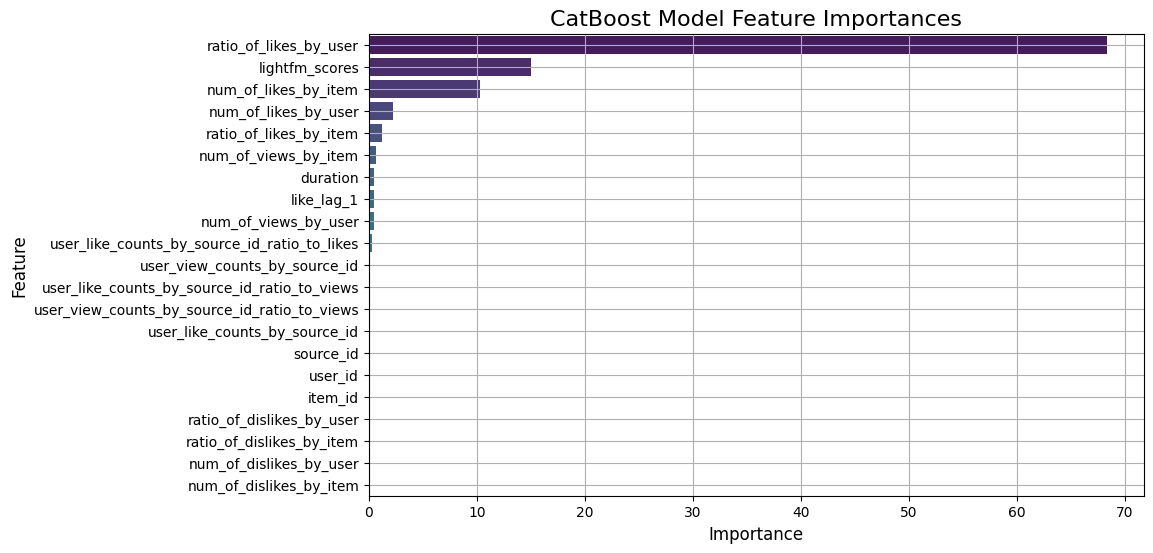

In [29]:
plot_feature_importances(model, graphic=True)

In [31]:
evaluate(val_df.user_id.values,
         val_df[target].values,
         catboost_proba[:,1])

100%|██████████| 181721/181721 [00:49<00:00, 3672.56it/s]


0.6468600584223315

In [ ]:
evaluate(val_df.user_id.values,
         val_df[target].values,
         catboost_proba[:,1])

100%|██████████| 181721/181721 [00:49<00:00, 3653.69it/s]


0.6462470775799961

### submission

In [37]:
test_proba = model.predict_proba(test_pairs_data_w_group_features)

In [38]:
test_pairs_data["predict"] = test_proba[:,1]
test_pairs_data.to_csv("./cbc_group_fs_on_last_10e6_submission.csv",index=False)